In [77]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
import math

a = 1000.05624604543e-3
b = 10.6068254211646e-3

f1 = 0.0e-3
f2 = f1 + 2.0 * math.sqrt(a * a + b * b)

# parabola part
p = 0.0562460454334836e-3

# whole mirror
WD = 1902.50110774383e-3
ML = 200.0e-3

param1 = 1.0 / (a * a)
param2 = -(f1 + f2) / (a * a) + 4.0 * p / (b * b)
param3 = math.pow(f1 + f2, 2) / (4.0 * a * a) - 4.0 * p * (p + f2) / (b * b) - 1.0
seam = (-param2 - math.sqrt(param2**2 - 4.0 * param1 * param3)) / (2.0 * param1)

def parabola(z):
    return math.sqrt(-4.0 * p * (z - p - f2))
def hyperbola(z):
    return b * math.sqrt((z - (f1 + f2) / 2)**2 / a**2 - 1.0)

entrance_radius = parabola(f1 - WD - ML)
seam_radius = parabola(seam)
exit_radius = hyperbola(f1 - WD)
ring_radius = seam_radius * WD / (f1 - seam)

In [26]:
# 理想集光

def getIdealFocus(exit_length, N):

        x = cp.linspace(-0.5 * exit_length, 0.5 * exit_length, N)
        y = x.copy()
        x, y = cp.meshgrid(x, y)

        ring = cp.zeros((N, N))

        r = cp.hypot(x, y)
        ring[(ring_radius <= r) & (r <= exit_radius)] = 1.0

        focus = cp.fft.fftshift(cp.fft.fft2(cp.fft.fftshift(ring)))
        return focus / math.sqrt(cp.sum(cp.abs(focus)**2))

class IdealFocusSimulator():

    def __init__(self, wavelength, exit_length, N):
        self.wavelength = wavelength
        
        self.exit_length = exit_length
        self.N = N
        self.focus_length = N * WD * wavelength / exit_length

    def getIdealFocus(self):
        self.focus = getIdealFocus(self.exit_length, self.N)
        self.focus_intensity = cp.abs(self.focus)**2
        self.focus_profile = self.focus_intensity[:, self.N//2]
        return self.focus

    def getFocusIntensity(self):
        return self.focus_intensity
    
    def getFocusProfile(self):
        return self.focus_profile
   
    def getFWHM(self):
        x = cp.linspace(-0.5 * self.focus_length, 0.5 * self.focus_length, self.N)
        focus_max = cp.max(self.focus_profile)
        diff = self.focus_profile - 0.5 * focus_max

        min_index = cp.argmin(cp.abs(diff))
        return 2.0 * abs(x[min_index])
    
    def getHPD(self):
        x = cp.linspace(-0.5 * self.focus_length, 0.5 * self.focus_length, self.N)
        y = x.copy()
        x, y = cp.meshgrid(x, y)
        r = cp.hypot(x, y)

        whole_sum = cp.sum(self.focus_intensity)

        hpr = 0.25 * self.focus_length
        step = hpr
        while True:
            ratio = cp.sum(self.focus_intensity[r <= hpr]) / whole_sum
            step /= 2
            if step < self.focus_length / self.N:
                break
            if ratio > 0.5:
                hpr -= step
            else:
                hpr += step

        return 2 * hpr

In [27]:
def showImg(cp_array):
    plt.imshow(cp.asnumpy(cp_array), origin='lower')

In [67]:
np.round(1.0e+6 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)][::85]))

array([-128.,  -43.,   43.,  128.])

exit_length: 1.2039027009802956
exit_length/exit_diameter: 20.828146006474576
FWHM: 1.5003663003662844e-05
HPD: 0.001738
HPD (arcsecond): 49.79003239686853


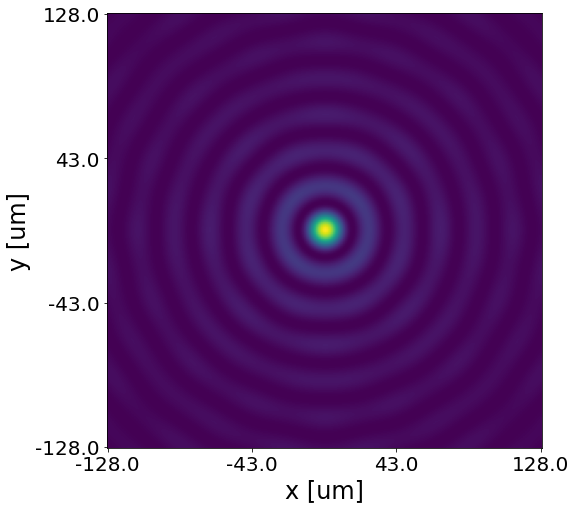

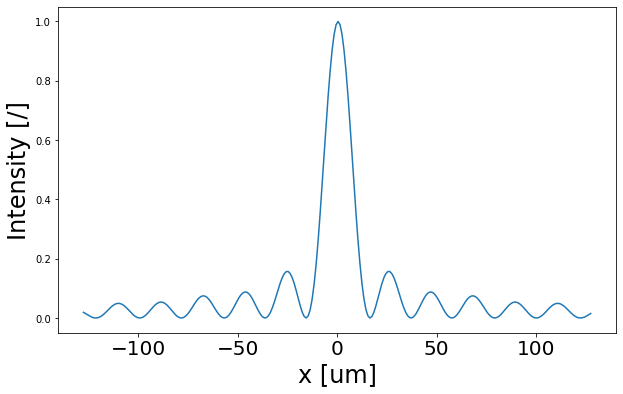

In [85]:
# 可視光

wavelength = 632.8e-9
N = 4096
focus_pixel_size = 1.0e-6
focus_length = N * focus_pixel_size
exit_length = N * WD * wavelength / focus_length
print('exit_length:', exit_length)
print('exit_length/exit_diameter:', exit_length / (2 * exit_radius))

sim = IdealFocusSimulator(wavelength, exit_length, N)
focus = sim.getIdealFocus()
focus_intensity = sim.getFocusIntensity()
                      
K = 256
fig = plt.figure(figsize=(8, 8))
showImg(cp.abs(focus[(N//2-K//2):(N//2+K//2),(N//2-K//2):(N//2+K//2)])**2)
plt.xticks(np.linspace(0, K-1, 4), np.round(1.0e+6 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)][::85])), fontsize=20)
plt.yticks(np.linspace(0, K-1, 4), np.round(1.0e+6 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)][::85])), fontsize=20)
plt.xlabel('x [um]', fontsize=24)
plt.ylabel('y [um]', fontsize=24)
fig.savefig('../../thesis/chap2/figure/ideal/focus_visible.png')

focus_profile = sim.getFocusProfile()
x = cp.linspace(-0.5 * focus_length, 0.5 * focus_length, N)

fig = plt.figure(figsize=(10, 6))
plt.xlabel('x [um]', fontsize=24)
plt.ylabel('Intensity [/]', fontsize=24)
plt.plot(1.0e+6 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)]), cp.asnumpy(focus_profile[(N//2-K//2):(N//2+K//2)] / cp.max(focus_profile[(N//2-K//2):(N//2+K//2)])))
plt.xticks(fontsize=20)
fig.savefig('../../thesis/chap2/figure/ideal/focus_profile_visible.png')

fwhm = sim.getFWHM()
print('FWHM:', fwhm)

hpd = sim.getHPD()
print('HPD:', hpd)

print('HPD (arcsecond):', hpd / 2000e-3 / math.pi * 180 * 1000)

exit_length: 0.5896992433562775
exit_length/exit_diameter: 10.202105145649272
FWHM: 7.0017094017098175e-09
HPD: 8.700000000000001e-07
HPD (arcsecond): 0.024923664088190814


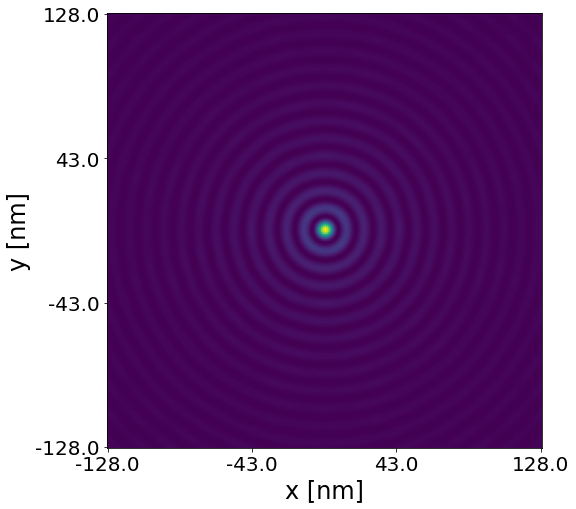

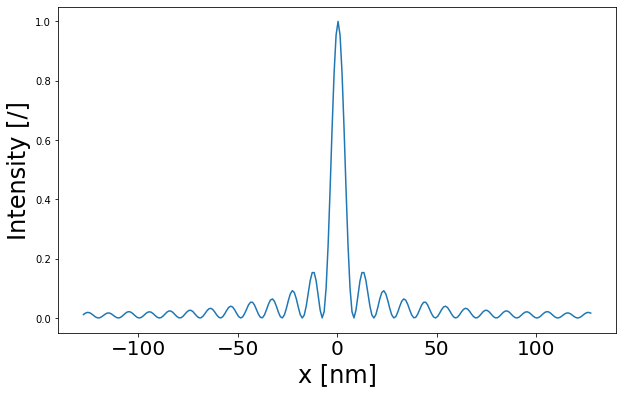

In [88]:
# X線 (4keV)

wavelength = 0.30996e-9
N = 4096
focus_pixel_size = 1.0e-9
focus_length = N * focus_pixel_size
exit_length = N * WD * wavelength / focus_length
print('exit_length:', exit_length)
print('exit_length/exit_diameter:', exit_length / (2 * exit_radius))

sim = IdealFocusSimulator(wavelength, exit_length, N)
focus = sim.getIdealFocus()
                      
K = 256
fig = plt.figure(figsize=(8, 8))
showImg(cp.abs(focus[(N//2-K//2):(N//2+K//2),(N//2-K//2):(N//2+K//2)])**2)
plt.xticks(np.linspace(0, K-1, 4), np.round(1.0e+9 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)][::85])), fontsize=20)
plt.yticks(np.linspace(0, K-1, 4), np.round(1.0e+9 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)][::85])), fontsize=20)
plt.xlabel('x [nm]', fontsize=24)
plt.ylabel('y [nm]', fontsize=24)
fig.savefig('../../thesis/chap2/figure/ideal/focus_xray.png')

focus_profile = sim.getFocusProfile()
x = cp.linspace(-0.5 * focus_length, 0.5 * focus_length, N)

fig = plt.figure(figsize=(10, 6))
plt.xlabel('x [nm]', fontsize=24)
plt.ylabel('Intensity [/]', fontsize=24)
plt.plot(1.0e+9 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)]), cp.asnumpy(focus_profile[(N//2-K//2):(N//2+K//2)] / cp.max(focus_profile[(N//2-K//2):(N//2+K//2)])))
plt.xticks(fontsize=20)
fig.savefig('../../thesis/chap2/figure/ideal/focus_profile_xray.png')

fwhm = sim.getFWHM()
print('FWHM:', fwhm)

hpd = sim.getHPD()
print('HPD:', hpd)

print('HPD (arcsecond):', hpd / 2000e-3 / math.pi * 180 * 1000)

exit_length: 1.2039027009802956
exit_length/exit_diameter: 20.828146006474576


<ipython-input-84-6b227d0f8871>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=np.round(1.0e+6 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)][::85])), fontsize=20)
<ipython-input-84-6b227d0f8871>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=np.round(1.0e+6 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)][::85])), fontsize=20)


FWHM: 1.5003663003662844e-05
HPD: 0.001738
HPD (arcsecond): 49.79003239686853


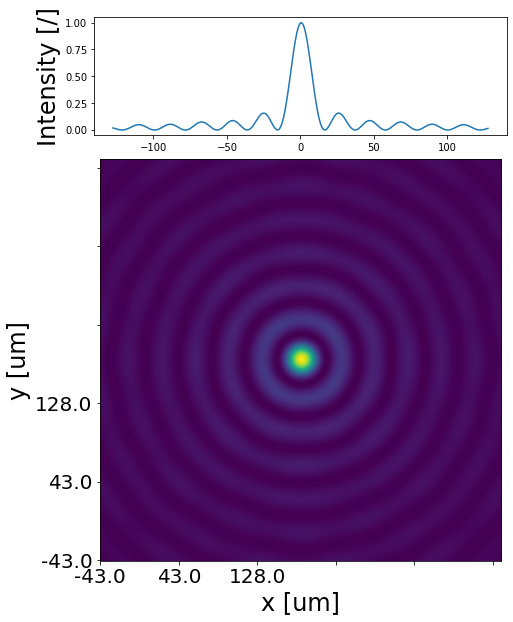

In [84]:
# なんかいい感じのsubplotできないか実験

wavelength = 632.8e-9
N = 4096
focus_pixel_size = 1.0e-6
focus_length = N * focus_pixel_size
exit_length = N * WD * wavelength / focus_length
print('exit_length:', exit_length)
print('exit_length/exit_diameter:', exit_length / (2 * exit_radius))

sim = IdealFocusSimulator(wavelength, exit_length, N)
focus = sim.getIdealFocus()
focus_intensity = sim.getFocusIntensity()
                      
K = 256
fig = plt.figure(figsize=(10, 10))

gs = gridspec.GridSpec(4, 4)
ax = fig.add_subplot(gs[1:, 0:3])
ax.imshow(cp.asnumpy(focus_intensity[(N//2-K//2):(N//2+K//2),(N//2-K//2):(N//2+K//2)]), origin='lower')
#ax.set_xticks(np.linspace(0, K-1, 4), np.round(1.0e+6 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)][::85])), fontsize=20)
ax.set_xticklabels(labels=np.round(1.0e+6 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)][::85])), fontsize=20)
ax.set_yticklabels(labels=np.round(1.0e+6 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)][::85])), fontsize=20)
#ax.set_yticks(np.linspace(0, K-1, 4), np.round(1.0e+6 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)][::85])), fontsize=20)
ax.set_xlabel('x [um]', fontsize=24)
ax.set_ylabel('y [um]', fontsize=24)
fig.savefig('../../thesis/chap2/figure/ideal/focus_visible.png')

focus_profile = sim.getFocusProfile()
x = cp.linspace(-0.5 * focus_length, 0.5 * focus_length, N)

#fig = plt.figure(figsize=(10, 6))
#plt.xlabel('x [um]', fontsize=24)
ax = fig.add_subplot(gs[0, 0:3])
ax.set_ylabel('Intensity [/]', fontsize=24)
ax.plot(1.0e+6 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)]), cp.asnumpy(focus_profile[(N//2-K//2):(N//2+K//2)] / cp.max(focus_profile[(N//2-K//2):(N//2+K//2)])))
#ax.set_xticklabels(fontsize=20)

ax = fig.add_subplot(gs[0, 0:3])
ax.set_ylabel('Intensity [/]', fontsize=24)
ax.plot(1.0e+6 * cp.asnumpy(x[(N//2-K//2):(N//2+K//2)]), cp.asnumpy(focus_profile[(N//2-K//2):(N//2+K//2)] / cp.max(focus_profile[(N//2-K//2):(N//2+K//2)])))
#ax.set_xticklabels(fontsize=20)

fwhm = sim.getFWHM()
print('FWHM:', fwhm)

hpd = sim.getHPD()
print('HPD:', hpd)

print('HPD (arcsecond):', hpd / 2000e-3 / math.pi * 180 * 1000)